In [80]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold, cross_val_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import shap
import settings

In [81]:
regression_targets = f'{settings.raw_data_folder}control/regression_targets.csv'
control = f'{settings.processed_data_folder}control_selected_features.csv'

In [82]:
targets = pd.read_csv(regression_targets, index_col=False)

In [83]:
df = pd.read_csv(control, index_col=0)

In [84]:
df = pd.merge(targets, df, on='Country')

In [85]:
df.head()

,Country,Deaths,Confirmed,Active,Recovered,Obesity,Population,Max Latitude,Max Longitude,Annual Average Temperature
0,Afghanistan,0.006186,0.142134,0.012574,0.123374,0.037471,0.027721,0.602919,0.700916,0.689775
1,Albania,0.050951,2.967301,1.123714,1.792636,0.454333,0.001985,0.639673,0.547690,0.671682
2,Algeria,0.006558,0.244897,0.070767,0.167572,0.555035,0.031592,0.590785,0.521881,0.888663
3,Angola,0.001461,0.061687,0.003419,0.056808,0.091335,0.023153,0.226062,0.556283,0.856803
4,Antigua and Barbuda,0.007143,0.293878,0.095918,0.190816,0.379391,0.000031,0.420557,0.312344,0.952521


In [86]:
columns = df.columns.tolist()
columns.remove('Country')

In [87]:
features = df.columns.tolist()

In [88]:
features.remove('Confirmed')
features.remove('Active')
features.remove('Recovered')
features.remove('Deaths')
features.remove('Country')

In [89]:
df = df[df['Deaths'] != 0]

In [90]:
df = df.drop(['Confirmed', 'Active', 'Recovered'], axis=1)

In [91]:
X = df[features]

In [92]:
Y = df['Deaths']

In [93]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [94]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
y_pred = model.predict(X_test)

In [96]:
pred_real = []
pred_real.append(y_pred.tolist())
pred_real.append(y_test.tolist())
pred_real.append(range(0, len(y_test.tolist())))

In [97]:
indexes = y_test.index.tolist()

In [98]:
test_countries = df.loc[indexes, :]['Country']

In [99]:
pred_real_df = pd.DataFrame(pred_real).T

In [100]:
pred_real_df.columns = ['Predicted', 'Real', 'No']

In [101]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE {mae: .4f}")

MAE  0.0229


In [102]:
print('==REAL= <=> =PRED==')
i = 0
for real, pred in zip(y_test, y_pred):
    print(f"{i}:{real: .3f}  <=>  {pred: .3f}  ")
    i+=1

==REAL= <=> =PRED==
0: 0.002  <=>   0.001  
1: 0.094  <=>   0.135  
2: 0.012  <=>   0.065  
3: 0.005  <=>   0.006  
4: 0.001  <=>   0.000  
5: 0.077  <=>   0.052  
6: 0.100  <=>   0.090  
7: 0.033  <=>   0.020  
8: 0.006  <=>  -0.001  
9: 0.004  <=>   0.008  
10: 0.014  <=>   0.096  
11: 0.026  <=>   0.037  
12: 0.009  <=>   0.005  
13: 0.038  <=>   0.034  
14: 0.054  <=>   0.092  
15: 0.004  <=>   0.001  
16: 0.001  <=>   0.001  
17: 0.003  <=>   0.005  
18: 0.167  <=>   0.073  
19: 0.129  <=>   0.120  
20: 0.069  <=>   0.038  
21: 0.026  <=>   0.048  
22: 0.009  <=>   0.007  
23: 0.000  <=>   0.030  
24: 0.128  <=>   0.139  
25: 0.010  <=>   0.044  
26: 0.013  <=>   0.060  
27: 0.005  <=>   0.015  
28: 0.011  <=>   0.065  
29: 0.059  <=>   0.098  
30: 0.051  <=>   0.077  
31: 0.122  <=>   0.089  
32: 0.004  <=>   0.000  
33: 0.006  <=>   0.001  
34: 0.024  <=>   0.014  
35: 0.010  <=>   0.043  
36: 0.001  <=>   0.044  
37: 0.009  <=>   0.004  
38: 0.038  <=>   0.090  


In [103]:
pred_real_df['Country'] = test_countries.tolist()

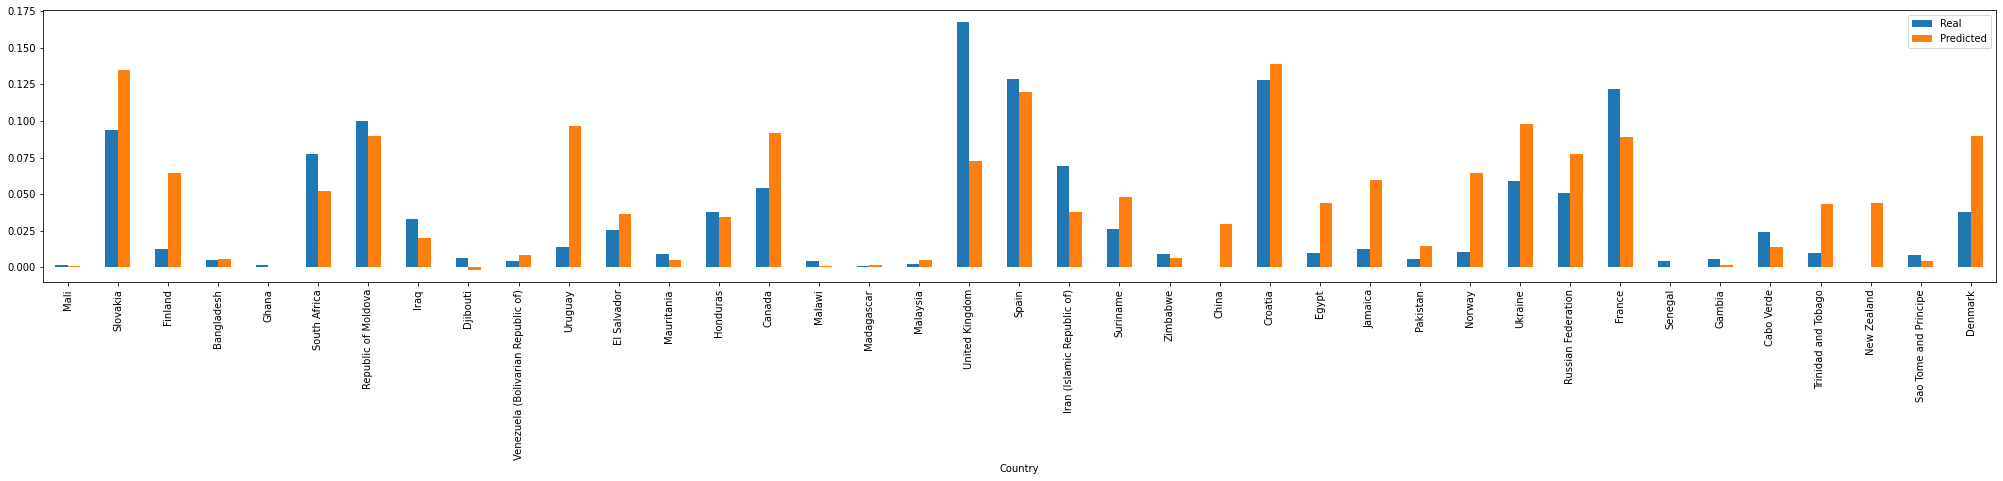

In [110]:
pred_real_df.plot(x="Country", y=["Real", "Predicted"], kind="bar", figsize=(35,5), width = 0.5)
plt.savefig(f'./control_predictions.png', dpi=300, bbox_inches = "tight")

In [105]:
print(model.feature_importances_)

[0.14638802 0.10862001 0.24835658 0.23732169 0.2593137 ]


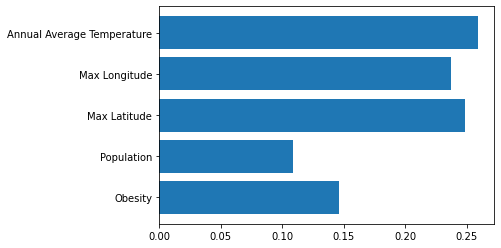

In [106]:
plt.barh(features, model.feature_importances_)
plt.show()

In [107]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

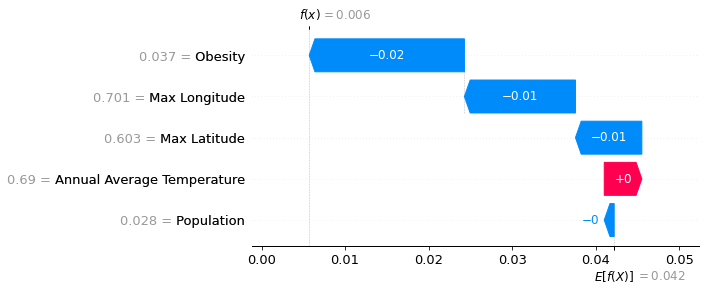

In [108]:
shap.plots.waterfall(shap_values[0])

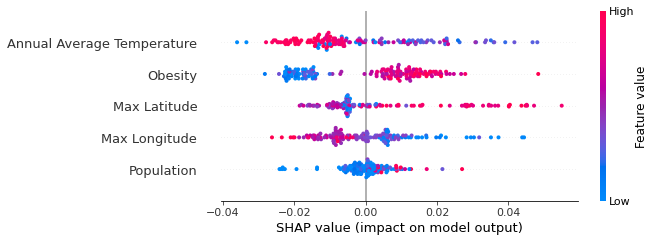

<Figure size 432x288 with 0 Axes>

In [111]:
shap.plots.beeswarm(shap_values)
plt.savefig(f'./control_xgboost_shap.png', dpi=300, bbox_inches = "tight")

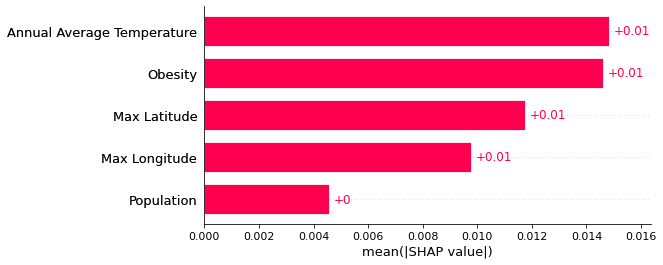

In [79]:
shap.plots.bar(shap_values)